In [72]:
# For the Glory of God
# Import required packages and tools: 
from collections import Counter
from cantera import Solution
from cantera._cantera import ConstPressureReactor, ReactorNet
from matplotlib.pyplot import plot, show
import matplotlib.pyplot as plt
from numpy.ma import array, arange
import pandas as pd
import numpy as np

# Create t vector
milliseconds = 0.001;
dt = 0.001*milliseconds;
tau_mix = 0.05*milliseconds;
omega = 1/tau_mix;
end_time = 0.5*milliseconds;
t = arange(0, end_time, dt)

In [73]:
def H_sens(tp):
    h_mass = tp.enthalpy_mass
    tempReactor = Solution('gri30.xml'); 
    tempReactor.TPX = [298.15, 101325.0000, tp.X]; 
    h_sens = tp.enthalpy_mass - tempReactor.enthalpy_mass;
    return h_sens

def H_chem(Y):
    tempReactor = Solution('gri30.xml'); 
    tempReactor.TPY = [298.15, 101325.0000, Y]; 
    return tempReactor.enthalpy_mass;

In [74]:
def iem(m, tpArray, rArray, rn, dt, omega):
# Constant k:
    C_phi = 1;
    k = -C_phi * omega * 0.5 * dt;
# Calculate average: 
    m_total_r = 1/sum(m)
#     H_total = 0; 
#     h_sens = array([H_sens(tpArray[i]) for i in range(0, len(tpArray))]); 
#     Hsens = m * h_sens
    M_species_total = sum([m[i] * tpArray[i].Y for i in range(0, len(tpArray))]); 
#     H_sens_total = sum(Hsens);    
    H_total = sum([m[i]*tpArray[i].enthalpy_mass for i in range(0, len(tpArray))]);

    Y_avg = M_species_total * m_total_r # Y_species_avg = (M_total_species)/(M_total_system)
    h_avg = H_total * m_total_r; # H_avg is the specific mass-weighted average across all reactors of the total enthalpy.
# Adjust reactor state:     
    for i in range(0, len(tpArray)):
        Y_current = tpArray[i].Y;
        Y_new =  Y_current + k * (Y_current - Y_avg);         
        h = tpArray[i].enthalpy_mass;
#         h_sens_new = h_sens[i] + k * (h_sens[i] - h_avg);
        h_new = h + k * (h - h_avg);
        tpArray[i].HPY = [h_new, tpArray[i].P, Y_new]
        rArray[i].syncState();

# Reinitialize reactor network solver:         
    rn.reinitialize();

In [75]:
def createReactorNetwork():
    m = array([1, 8, 0.5]);
    s1 = Solution('gri30.cti');
    s2 = Solution('gri30.cti');
    s3 = Solution('gri30.cti');

    s1.TPY = 300, 101325, 'H2:1';
    s2.TPY = [300, 101325, 'O2:1'];
    s3.TPX = [300, 101325, 'CH4:1,O2:2'];
    s3.equilibrate('HP');
    tpArray = array([s1, s2, s3])

    r1 = ConstPressureReactor(s1);
    r2 = ConstPressureReactor(s2);
    r3 = ConstPressureReactor(s3);
    rArray = array([r1, r2, r3])
    
    rn = ReactorNet([r1, r2, r3]);
    
    r1.syncState(); 
    r2.syncState(); 
    r3.syncState();
    rn.reinitialize()
    return m, tpArray, rArray, rn;

In [76]:
# gas1 = Solution('h2o2.cti'); 
# gas2 = Solution('h2o2.cti'); 
# gas3 = Solution('h2o2.cti'); 

# gas1.TPY = [600.00, 101325, 'H2O:1']; 
# gas2.TPY = [450.15, 101325, 'O2:1'];
# gas3.TPY = [900, 101325, 'H2O:0.5, H2:0.5']

# gases = [gas1, gas2, gas3]; 
# m = [3, 3, 7]
# h_sens_list = [H_sens(gases[i]) for i in range(0,3)]
# h_chem_list = [H_chem(gases[i]) for i in range(0,3)]

In [77]:
m, tpArray, rArray, rn = createReactorNetwork(); 
# Create table
columnNames = ['T'] + ['P'] + ['Enthalpy'] + tpArray[0].species_names 
timeHistory = [pd.DataFrame(columns=columnNames) for i in range(0,len(tpArray))]

counter = 0
for i in range(0, len(t)):
    for j in range(0, len(tpArray)):
        if(counter%10 == 0):        
            state = np.hstack([rArray[j].thermo.T, rArray[j].thermo.P, m[j]*tpArray[j].enthalpy_mass, 
                               rArray[j].thermo.Y])
            timeHistory[j].loc[t[i]] = state
    counter += 1
    iem(m, tpArray, rArray, rn, dt, omega) 
    rn.advance(t[i]);

Initial total enthalpy = -424859.913946 J
Final total enthalpy = -424852.051353 J


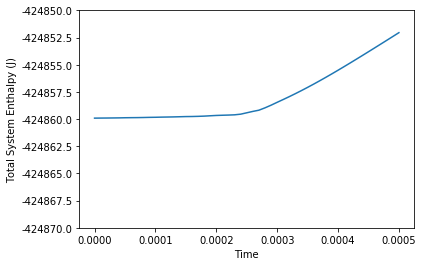

In [81]:
H_total = [timeHistory[i]['Enthalpy'] for i in range(0, len(tpArray))]
HH = sum(H_total)
%matplotlib inline
plt.figure();
ax = plt.gca();
ax.ticklabel_format(useOffset=False)
ax.plot(HH.index, HH)
plt.ylim([-424870, -424850])
ax.set_yticklabels(ax.get_yticks())
plt.xlabel('Time');
plt.ylabel('Total System Enthalpy (J)');
# ax.get_yaxis().get_major_formatter().set_useOffset(False)


print("Initial total enthalpy =", sum([timeHistory[i]['Enthalpy'][timeHistory[i].first_valid_index()] for i in range(0, len(tpArray))]), "J")
print("Final total enthalpy =", sum([timeHistory[i]['Enthalpy'][timeHistory[i].last_valid_index()] for i in range(0, len(tpArray))]), "J")

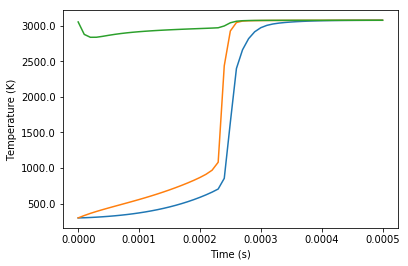

In [79]:
plt.figure()
ax = plt.gca();
ax.ticklabel_format(useOffset=False)
ax.plot(timeHistory[0].index, timeHistory[0]['T'],
         timeHistory[1].index, timeHistory[1]['T'],
         timeHistory[2].index, timeHistory[2]['T']) 
# plt.ylim([299.98, 300.02])
ax.set_yticklabels(ax.get_yticks())
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)');